# CS 594 / CS 690 - Assignment 07
### October 15, 2018
---

For this assignment, you must work in groups of one or two students. Each person is responsible to write their own code, but the group will (together) discuss their solution.  In this notebook, we provide you with basic functions for completing the assignment.  *Complete the assignment in this notebook.  You will need to modify existing code and write new code to find a solution*.  Each member of the group must upload their own work (i.e., a notebook file) to GitHub.

*Note: Running a cell will not rerun previous cells.  If you edit code in previous cells, you must rerun those cells.  If you are having trouble with undefined errors and code changes not applying, we recommend using* `Run All` *to avoid any errors results from not rerunning previous cells.  You can find this in the menu above:* `Cell -> Run All`

The National Health and Nutrition Examination Survey (NHANES) is a cross-sectional survey that is conducted every two years in the United States. As part of the survey, individuals are asked to complete a demographics questionnaire and a 24-hour dietary recall. The 24-hour dietary recalls have been shown to be a valid and reliable method for describing usual dietary intakes of a population.  Given the tens of thousands of different foods an individual may report in the NHANES dietary recall data, it is beneficial to group (i.e., cluster) similar foods based on macronutrient (and somethings micronutrient) content.  These food groups can be used to gain new insight into the dietary patterns of individuals and populations.  For example, if an individual eats only foods in the "high fat, low carbohydrate" group we may conclude that this individual is on the [ketogenic diet](https://en.wikipedia.org/wiki/Ketogenic_diet).

We provide a subset of all the food items which are reported in the NHANES dietary recall data.  The data is stored in a tab delimited file and each row contains information for a single food item.  The information we provide is listed in the table below:

| Feature      | Description                                                              |
|--------------|--------------------------------------------------------------------------|
| Food Code    | USDA provided 8-digit code that uniquely identifies each food item       |
| Carbohydrate | Carbohydrate content of food, in grams of carbohydrates per gram of food |
| Fat          | Fat content of food, in grams of fat per gram of food                    |
| Description  | A text description of the food item                                      |

Like many real world datasets, the NHANES dietary data exhibits characteristics which make analysis more difficult.  Data are missing values (e.g., certain values do not exist in the data), data features are on different scales or units (e.g., carbohydrates are reported in mg and fats are reported in g), and data values are invalid (e.g., the grams of fat for a food item was incorrectly recorded during data collection).  To perform effective data analysis, these factors must be considered.  We have normalized the data and removed invalid values for you.  The data is presented in 3 files and each line in a file contains information for one food item.  The first data file, `./data/data-1.csv`, contains all of the data (i.e., there are no missing values).  The second and third file, `./data/data-2.csv` and `./data/data-3.csv`, contain food items that are missing values for fat and carbohydrate content.  *In this assignment, you will need to develop methods to fix the problem of missing values in a dataset and cluster the food data based on macronutrient content.*

Below, we give code to help you get started.  We start a *Spark Context*, `sc`, and provide a function to load the data into a *Spark RDD* as a `(key, value)` pair.  The `key` is a tuple of `(food code, description)` and the value is a numpy array of `np.array([carbohydrate, fat])`.  It is important to note that we mark missing values in the NHANES dataset with a placeholder value: `np.nan`.  If you attempt to cluster the data without dealing with these missing values, you will encounter error messages.

In [28]:
# Note: If you are having trouble loading Spark, try uncommenting the following two lines
#import findspark
#findspark.init()

import numpy as np
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

# Function loads a food data text file and separates each row into (key, value) pair
# Input: fileName: 'location/of/file.csv'
#        delimiter: 'delimiter string', default='\t'
# Return: [('key', 'header'), ('data', 'header')], RDD <<(key, value), (key, value), ...>>
def loadFoodData(fileName, delimiter='\t'):
    # Load data values
    csv_data = sc.textFile(fileName)
    split_data = csv_data.map(lambda x: x.split(delimiter))
    
    # Separate header from data
    header = split_data.first()
    data = split_data.filter(lambda x: x!=header)
    
    # Fill missing values with marker values (i.e., np.nan)
    missing_data = data.map(lambda x: [val if val!='' else np.nan for val in x])
    
    # Map the data to (key, value) pairs
    kv_data = missing_data.map(lambda x: ((x[0], x[3]), np.array((x[1], x[2]), dtype='float32')))
    kv_header = [(header[0], header[3]), (header[1], header[2])] # Match header to kv_data
    
    return kv_header, kv_data


# Load the data in the first file
header, data = loadFoodData('./data/data-1.csv')

# Look at the column names and the first row of data
print(header)
print(data.collect()[0])

[('Food Code', 'Description'), ('Carbohydrate', 'Fat')]
(('11100000', 'MILK, NFS'), array([0.04853348, 0.0191019 ], dtype=float32))


### Problem 1:

The first dataset we provide (i.e., `./data/data-1.csv`) contains no missing values.  We can cluster food items in this file based on carbohydrate and fat content to determine a proper value for $K$ (i.e., the number of clusters).  The clusters we find with this data will provide a ground truth for comparison to clusters we find later using datasets with missing values.  Last lecture, you developed your own k-Means implementation.  *In this assignment, you will use the well-known and optimized k-Means from Spark MLlib to cluster data points*.  Note that [k-Means](https://spark.apache.org/docs/2.2.0/mllib-clustering.html#k-means) is one of several machine learning models provided in the [Spark MLlib](https://spark.apache.org/docs/2.3.0/ml-guide.html).  Last lecture you learned about the **elbow method** to select a $K$ value given a dataset.  *Determine the optimal value for $K$ using the **elbow method** [[wiki](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_elbow_method), [example](https://pythonprogramminglanguage.com/kmeans-elbow-method/)].  Plot the results of the elbow method and the clusters you find.*

Below, is an example of how to use *k-Means* from *Spark MLlib*.  We import the model, train the model, and cluster the dataset of food items we previously loaded.

In [29]:
from pyspark.mllib.clustering import KMeans

# Get macronutrient values (i.e., drop keys)
data_values = data.map(lambda x: x[1])

# Cluster food items using k-Means and K=3
K = 3
model = KMeans.train(data_values, K, maxIterations=10, initializationMode='random')

# Look at the location of cluster centers
# HINT: ref [1]
print(model.clusterCenters)

# Show the cluster id of 10 randomply chosen food items
# HINT: ref [2]
cluster_ids = model.predict(data_values)
print(cluster_ids.takeSample(False, 10))

[array([0.09283897, 0.46140881]), array([0.11902118, 0.05828208]), array([0.64418215, 0.11063827])]
[1, 1, 1, 1, 2, 1, 2, 1, 1, 1]


Typically, the **elbow method** has y-axis values corresponding to *percent of variance explained*.  For our evaluation, we can use a different metric to measure the quality of the clusters.  There are many different metrics for cluster quality, which you can read about [here](https://en.wikipedia.org/wiki/Cluster_analysis#Internal_evaluation).  For this assignment, we will use [Within Set Sum of Squared Errors](https://en.wikipedia.org/wiki/Residual_sum_of_squares) (WSSSE).  This method is convenientally built into the Spark kMeans model and can be accessed with `model.computeCost()`:

In [30]:
# Compute the Within Set Sum of Squared Errors
# HINT: ref [3]
print(model.computeCost(data_values))

80.11017465559851


In the cell below, cluster food items and calculate WSSSE for $K$ values between 2 and 10.  Plot these values and determine an appropriate value for $K$.  *Remember, an appropriate value for $K$ can be found where the plot of **K vs. Within Set Sum of Squared Errors** becomes increasing horizontal (i.e., there is dimishing return in cluster quality as k increases).*

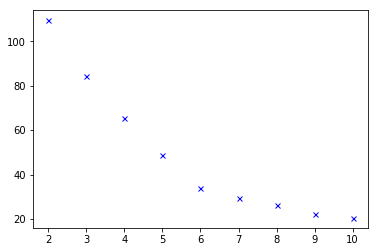

In [31]:
from matplotlib import pyplot as plt

# Train k-Means with k values in [2,10] and calculate WSSSE for each clustering
for K in range(2,11):
    model = KMeans.train(data_values, K, maxIterations=10, initializationMode='random')
    wsse = model.computeCost(data_values)
    plt.plot(K, wsse, marker='x', linestyle='-', color='b', markersize=5)
    
    
# Plot the WSSSE for different values of k


Now that you have used the elbow method, complete the code below to (1) define the optimal value for $K$, (2) cluster food items (using $K$), and (3) plot food clusters by *fat* and *carbohydrate* content.  *In the cell below, we provide a plotting function.  The expected input is an RDD containing macronutrient values and a list of integers corresponding to cluster label of each point (e.g., the output of `KMeansModel.predict()`).  Complete the definition of the `clusterAndPlotData()` function below.  It should cluster the data and plot clusters using the plotting function we provide.  This function will be used in problems 2 and 3 of this assignment.*

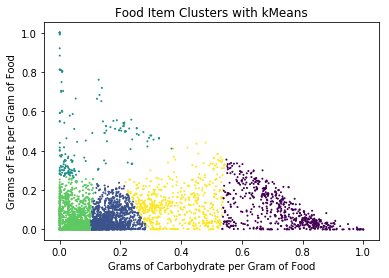

In [18]:
# Function plots 2D food clusters
# Input: data: RDD <<(carb1, fat1), (carb2, fat2), (carb3, fat3), ...>>
#        cluster_ids: list of cluster ID integers [0, 0, 1, 0, 2, 5, 3, 3, ...]
# Return: None (shows a plot)

def plotFoodClusters(data, cluster_ids):
    # Plot the clusters with a scatter plot
    # HINT: ref[4]
    data = np.array(data.collect())
    plt.scatter(data[:,0], data[:,1], c=cluster_ids, s=1)
    # Define axis labels and plot title
    plt.xlabel('Grams of Carbohydrate per Gram of Food')
    plt.ylabel('Grams of Fat per Gram of Food')
    plt.title('Food Item Clusters with kMeans')
    plt.show()
    plt.clf()

# Function clusters food items and plots clusters
# Input: data: RDD <<(carb1, fat1), (carb2, fat2), (carb3, fat3), ...>>
#        K: integer value for number of clusters
# Return: None (shows a plot)
def clusterAndPlotData(data, K):
    # Cluster food items using kMeans and input K value
    #data_values = data.map(lambda x: x[1])
    model = KMeans.train(data, K, maxIterations=10, initializationMode='random')
    
    # Get the cluster ID for each food item in the dataset.  
    # Cluster ID values are used to show clusters with color in plots
    cluster_ids = model.predict(data)
    plotFoodClusters(data, cluster_ids.collect())
    # Plot food clusters
    


# Define the optimal K value you found above.  It will be used for the remainder of the assignment!
K = 5

# Cluster and plot food items from ./data/data-1.csv
clusterAndPlotData(data_values, K)

**References:**
- [1: KMeansModel.clusterCenters](https://spark.apache.org/docs/2.2.0/api/python/pyspark.mllib.html#pyspark.mllib.clustering.KMeansModel.clusterCenters)
- [2: KMeansModel.predict](https://spark.apache.org/docs/2.2.0/api/python/pyspark.mllib.html#pyspark.mllib.clustering.KMeansModel.predict)
- [3: KMeansModel.computeCost](https://spark.apache.org/docs/2.2.0/api/python/pyspark.mllib.html#pyspark.mllib.clustering.KMeansModel.computeCost)
- [4: pyplot.scatter](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html)

## Don't forget to shelve your Jetstream instance when you're not using it!

### Problem 2:
The second dataset we provide you (i.e., `./data/data-2.csv`) is missing macronutrient values not at random.  Specifically, food items with carbohydrate values closer to `0.5` are more likely to be missing the carbohydrate value.  *Define a method to remove missing values (i.e., remove food items with missing data) and apply this method to the data.  Cluster the modified data (using the $K$ you selected in problem 1) and plot the resulting clusters*.  Below, we provide code that loads the data and reports the percentage of missing macronutrient values.

In [19]:
# Load the data in the second file
header, data = loadFoodData('./data/data-2.csv')

data_values = data.map(lambda x: x[1])

# Find out how much data is missing
# Remember, we mark missing values with np.nan in the loadFoodData function!
# HINT: Ref [1]
missing_data = data.map(lambda x: np.isnan(x[1]).astype('int32'))
missing_count = missing_data.reduce(np.add)
percent_missing = (missing_count * 100) / data.count()
print('{:.2f}% of Carbohydrate and {:.2f}% of Fat values missing!'.format(*percent_missing))

10.14% of Carbohydrate and 0.00% of Fat values missing!


In the cell below, complete the definition of a function to remove food items with missing macronutrient values.

In [20]:
# Define a function to remove food items with any missing macronutrient values
# HINT: refs [1,2,3]
import pandas as pd

def removeMissing(data):
    data = pd.DataFrame(data).dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
    data = data.values
    data = sc.parallelize(data)
    data_no_missing_values = data.map(lambda x: x[1])
    return data_no_missing_values
removeMissing(data.collect())

PythonRDD[926] at RDD at PythonRDD.scala:49

In the following cell, remove missing values in the data with the function you defined above, apply k-Means, and plot the clusters (using the function you wrote in problem 1).

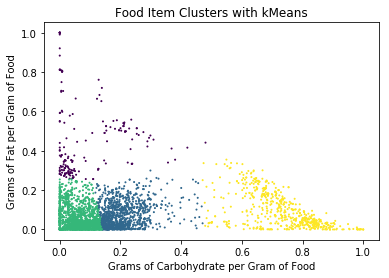

In [21]:
# Remove food items with missing macronutrient values
data_no_missing_values = removeMissing(data.collect())

clusterAndPlotData(data_no_missing_values, 5)
# Cluster and plot food items


**References:**
- [1: numpy.isnan](https://docs.scipy.org/doc/numpy/reference/generated/numpy.isnan.html)
- [2: python any](https://docs.python.org/3/library/functions.html#any)
- [3: RDD.filter](https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html#filter)

## Don't forget to shelve your Jetstream instance when you're not using it!

### Problem 3:
The last dataset we provide you (i.e., `./data/data-3.csv`) is missing macronutrients values at random.  Specifically, any food item may be missing a value for fat or carbohydrate content (but not both).  *Define a method to fill missing macronutrient values with the mean of observed macronutrient values (i.e., for missing values in fat, fill with the mean of fat values that are present) and apply this method to the data.  Cluster the modified food data (using the $K$ you selected in problem 1) and plot the resulting clusters.  Additionally, apply the `removeMissing()` function from problem 2 and remove data with missing macronutrient values.  Cluster the modified food data (using the $K$ you selected in problem 1) and plot the resulting clusters*.  Below, we provide code that loads the data and reports the percentage of values missing macronutrient values.

In [22]:
# Load the data in the second file
header, data = loadFoodData('./data/data-3.csv')

data_values = data.map(lambda x: x[1])

# Find out how much data is missing
# Remember, we mark missing values with np.nan in the loadFoodData function!
# HINT: Ref [1]
missing_data = data.map(lambda x: np.isnan(x[1]).astype('int32'))
missing_count = missing_data.reduce(np.add)
percent_missing = (missing_count * 100) / data.count()
print('{:.2f}% of Carbohydrate and {:.2f}% of Fat values missing!'.format(*percent_missing))

9.25% of Carbohydrate and 10.59% of Fat values missing!


In the cell below, complete the definition of the function to fill missing macronutrient values with the mean of observed macronutrients values.

In [23]:
# Define a function that will fill missing values with a mean value
def fillMissingWithMean(data):
   
    data = pd.DataFrame(data).fillna(pd.DataFrame(data).mean())
    data = data.values
    
    data = sc.parallelize(data)
    data_mean_as_missing_values = data.map(lambda x: x[1])
    return data_mean_as_missing_values


In the following cell, fill missing macronutrient values in the data using the function you defined above, apply k-Means, and plot the food clusters.

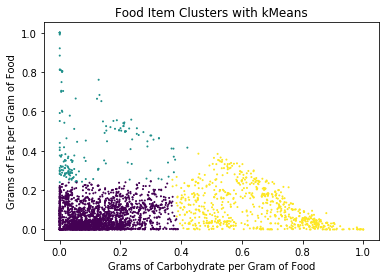

In [24]:
# Fill missing macronutrient values with mean macronutrient values
data_mean_as_missing_values = fillMissingWithMean(data.collect())

clusterAndPlotData(data_mean_as_missing_values, 5)

# Cluster and plot


How would removing data with missing macronutrient values affect this dataset?  Remember, about 20% of the data has a missing macronutrient value.  In the following cell, remove food items with missing macronutrient values with the function you defined in problem 2, apply k-Means, and plot the food clusters.

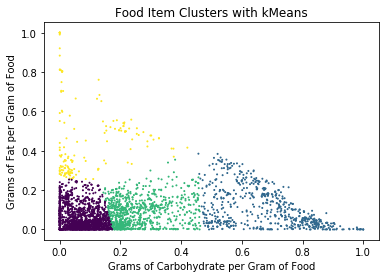

In [26]:
# Remove food items with missing macronutrient values
data_no_missing_values = removeMissing(data.collect())

clusterAndPlotData(data_no_missing_values, 5)
# Cluster and plot food items

# Cluster and plot



## Don't forget to shelve your Jetstream instance when you're not using it!

### Problem 4:
In this assignment, you learned how to use the k-Means provided by *Spark's MLlib*, apply the elbow method, and deal with missing data.  Answer the questions below based on the results you obtained above.

**Can you summarize your findings in each problem? Can you compare and contrast the findings across problems? How did each method for dealing with missing data (i.e., remove or filling) change the clustering outcome?**

*Your answers here*

In [ ]:
Since remove method loses a certain portion of the data, the clustering is less dense. It seems like values that are
not neighbours are also grouped together. But will filling method we do not lose any data. With more information it
certainly helps the algorithm to find the nearest neighbours and form a group with them

**What value did you choose for $K$ in Problems 1-3? You based the selection of $K$ on the first dataset (i.e., no missing data). Do you expect a different value of $K$ if you had used elbow method with the second or third dataset? If yes, propose changes to your current solutions.**

*Your answers here*

In [ ]:
With elbow method, I chose the value 5. I believe, different dataset could have produced a different K value. While 
calling the "clusterAndPlotData()" function, instaed of hardcoding the argument value as 5, I would have first 
run the elbow method, and then pass the value after making a decision on the k value

**Now look at the plot of clusters in Problem 1. Logically, there cannot be more than 1 gram of (carbohydrate + fat) in 1 gram of food. In your plot this can be seen in the form of a diagonal line from the top-left to bottom-right (where the sum of fat and carbohydrate content is equal to 1). How can you use this information to improve the way you fill missing values? Can you think of other methods to fill missing values? (HINT: logistic regression)**

*Your answers here*

In [ ]:
We can use logistic regression to build a predictive model and instead of filling in the values with mean, we can 
fill the values with the results of the prediction

### Things to Consider:
kMeans is a clustering method that is easy to implement due to its simplicity.  More sophisticated clustering methods may provide better food groups.  Review this [overview of clustering methods](http://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods).  How would you choose a clustering method for other datasets?

### Assignment Questions:
**Answer the following questions, in a couple sentences each, in the cells provided below**
* List the key tasks you accomplished during this assignment?
* Describe the challenges you faced in addressing these tasks and how you overcame these challenges?
* Did you work with other students on this assignment? If yes, how did you help them? How did they help you? Be as specific as possible.

In [ ]:
I accomplished data processing in two differernt methods - removing the missing values and filling in the missing 
values with mean values. This assignment was not much challenging. I think interpreting the data and the results 
clustering and figuring out the accuracy of the result is challenging. I worked mostly by myself. My friends and I
cross matched our outputs to determine the accuracy of the results. 

*Your answers here*

## Don't forget to shelve your Jetstream instance when you're not using it!